In [57]:
import pandas as pd
import os
import openpyxl
import xlsxwriter
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
import numpy as np
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess

In [3]:
### Function 1: get imageID and flagellaID (same if only 1 flagellum in the image)
### from linescan .csv filename
# input : linescan filename
# output: imageID, flagellaID

def imageID_flagellaID_from_linescan(filename):
    flagellaID = []
    if "_TUB.csv" in filename:
        flagellaID = filename.split('_TUB.csv')
#         print(flagellaID)
    elif "_HA.csv" in filename:
        flagellaID = filename.split('_HA.csv')
#         print(flagellaID)
    # else:
    #     continue

    #for cells w 2 measured flagella, filter out additional identifier(s)
    imageID = ''
    biflagID = ['btm','top','L','R']
    for i in biflagID:
        if i in flagellaID[0]:
            imageID = flagellaID[0].split('_'+i)[0]
    if imageID == '':
        imageID = flagellaID[0]
    
    return imageID, flagellaID[0]


In [4]:
### Function 2: Background Subtraction
# input : background csv directory, imageID, list of raw data for each channel
# output : background-subtracted lists for each channel

def background_subtraction(bg_dir, imageID, raw_TUB, raw_HA, z_size):
    bg_df = pd.read_csv(bg_dir)
    label_col = bg_df['Label']
    row = 0
    TUB_row = None
    HA_row = None
#     print("imageID", imageID)
#     print("label_col", label_col)
    for x in label_col:
        if imageID in x:
            #print("x", x)
    #         print(row)
            if x.endswith('1'):
                TUB_row = row
            elif x.endswith('2'):
                HA_row = row
        row+=1
#     print(TUB_row, HA_row)

    # divide by z_size for Avg Slices, input 1 for z_size if Sum Slices

#     print(bg_df['Mean'], "TUB_row", TUB_row)
    TUB_bg = bg_df['Mean'][TUB_row] / z_size
    HA_bg = bg_df['Mean'][HA_row] / z_size
#     print(bg_df['Mean'][TUB_row], z_size, TUB_bg, HA_bg)


    # perform background subtraction, create list
    TUB_bgsub = []
    for x in raw_TUB:
        #print(x, x - TUB_bg)
        TUB_bgsub.append(x - TUB_bg)

    HA_bgsub = []
    for x in raw_HA:
        HA_bgsub.append(x - HA_bg)
    
    return TUB_bgsub, HA_bgsub

In [6]:
### Function 3 - Find z size

updated_results_dir = 'C:/Users/Mary/Documents/Shared folder/Karina/HA in Flagella/Sum Slices data/Raw Data'
flagdata = "2_17_2021_slide_3b_001-1_L_HA"

def find_z_size(imageID,metadata_dir):
    img_metadata = pd.read_excel(metadata_dir + '/' "image metadata.xlsx",
                                 sheet_name="All Complement")
    foundmatch = False
    for row in img_metadata['Index']:
    #     print(img_metadata['file'][row])
    #     print(img_metadata['slide'][row])
    #     print(img_metadata['image'][row])
    #     print(img_metadata['z size'][row])
    #     print(img_metadata['date'][row])

        img_file = img_metadata['file'][row]
        slide = img_metadata['slide'][row]
        img_num = img_metadata['image'][row]
        date = img_metadata['date'][row]
        z_size = img_metadata['z size'][row]

        #add zeros to image ID
        count = 0
        temp_num = img_num
        while(temp_num > 0):
            temp_num = temp_num//10
            count +=1
        #print(temp_num)

        if count == 0 or count == 1:
            img_num = "00" + str(img_num) 
        elif count == 2:
            img_num = "0" + str(img_num)

        #print(img_num)

        if slide in flagdata and img_num in flagdata and date in flagdata:
            foundmatch = True
            return z_size,img_file
    #           print(img_file)
    if foundmatch == False:
        return "no match"
        


In [41]:
### 1. extract data from linescans, create master file w each table in separate tab

updated_results_dir = 'C:/Users/Mary/Documents/Shared folder/Karina/HA in Flagella/Sum Slices data/Raw Data'
linescan_dir = updated_results_dir + '/Linescans'
bg_dir = updated_results_dir + '/Background.csv'

#filename = '1b_2_17_2021_005-1_L_HA.csv'
newxlsx = pd.ExcelWriter("all_linescans_preprocessed.xlsx", engine='xlsxwriter')

os.chdir(linescan_dir)
for filename in os.listdir():
#     print(filename)
    
    #split filename (flagellaID) from channel name
    imageID = imageID_flagellaID_from_linescan(filename)[0]
    flagellaID = imageID_flagellaID_from_linescan(filename)[1]
#    print(imageID)

    #read file as flagellaID + TUB channel, create dataframe
    flag_df = pd.read_csv(linescan_dir + '/' + flagellaID + "_TUB.csv")
    flag_TUB = flag_df.rename(columns={'Distance_(microns)':'x', 'Gray_Value':'raw TUB SS'})
    #read HA channel, save only intensity column & joint to main df
    
    flag_HA = pd.read_csv(linescan_dir + '/' + flagellaID + "_HA.csv")
    flag_HA_1 = flag_HA.rename(columns={'Distance_(microns)':'x', 'Gray_Value':'raw HA SS'})
    HA_int = flag_HA_1[['raw HA SS']]
    flag_df = flag_TUB.join(HA_int)
    
    # normalize x axis
    x_max = flag_df['x'][len(flag_df)-1]
    flag_df['Norm x'] = flag_df['x']/x_max
    #print(flag_df)
    
    #get z-size, Avg Slices from Sum Slices projection
    z_size_func = find_z_size(imageID, updated_results_dir)
    z_size = z_size_func[0]
    flag_df['raw TUB AS'] = flag_df['raw TUB SS']/z_size
    flag_df['raw HA AS'] = flag_df['raw HA SS']/z_size
#     print(flag_df)

    #normalization
        #BG subtraction
        # Sum slices - input 1 for z_size
    bgsub_SS = background_subtraction(bg_dir,imageID,flag_df['raw TUB SS'],flag_df['raw HA SS'],1)
    TUB_bgsub_SS = bgsub_SS[0]
    HA_bgsub_SS = bgsub_SS[1]
    flag_df['TUB BgSub SS'] = TUB_bgsub_SS
    flag_df['HA BgSub SS'] = HA_bgsub_SS
#     print(flag_df)    

        ## Avg Slices - input z_size for z_size
    #print(flagellaID)
    bgsub_AS = background_subtraction(bg_dir,imageID,flag_df['raw TUB AS'],flag_df['raw HA AS'],z_size)
    TUB_bgsub_AS = bgsub_AS[0]
    HA_bgsub_AS = bgsub_AS[1]
    flag_df['TUB BgSub AS'] = TUB_bgsub_AS
    flag_df['HA BgSub AS'] = HA_bgsub_AS
    
    #print(flag_df)
    #print(len(flag_df['raw TUB AS']),len(TUB_bgsub_AS))

    flag_df['HA/TUB AS'] = flag_df['HA BgSub AS'] / flag_df['TUB BgSub AS']
    
    
    ##normalize HA/TUB to starting intensity
#     int_i = flag_df['HA/TUB AS'][0]
#     norm_HA_TUB = []

#     for x in flag_df['HA/TUB']:
#         norm_HA_TUB.append(x / int_i)

#     #norm_HA_TUB
#     flag_df['Normalized HA/TUB'] = norm_HA_TUB
#     #flag_df

    ## Smoothing: Moving Average 
    MA_n = 3   # adjust (MA_n-x) as needed to align the curves in next line:
    sm_HA_TUB_AS = pd.Series(flag_df['HA/TUB AS']).rolling(window=MA_n).mean().iloc[MA_n-2:].values
    sm_HA_TUB_AS = np.append(sm_HA_TUB_AS,"NaN")
    flag_df['Smoothed HA/TUB AS'] = sm_HA_TUB_AS

    ##check data smoothing
#     plt.plot(norm_HA_TUB)
#     plt.plot(HA_TUB)
#     plt.plot(smooth_HA_TUB)
#     plt.plot(smooth_norm_HA_TUB, color = 'b')
#     plt.plot(norm_smooth_HA_TUB, color = 'r')

#     print(len(norm_HA_TUB))
#     print(len(smooth_norm_HA_TUB))
#     print(len(norm_smooth_HA_TUB))
#
    
    #create new master spreadsheet
    flag_df.to_excel(newxlsx,sheet_name=flagellaID.lower(),index=False)

newxlsx.save()
#print(flag_df)



IndexError: list index out of range

In [130]:
# Puncta Detection - 
# input: x & intensity data for 1 flagellum
# output : dataframe with puncta data for 1 flagellum - each column is 1 punctum

def puncta_detection(norm_x, raw_x, int_col,avg_int, std_int, sourcedata, sheet):
    num_puncta_per_flag = {}

    # dataframe to detect puncta boundaries
    smoothed = sourcedata[sheet]['Smoothed HA/TUB AS']
    sm_avg = smoothed.describe()[1]
    sm_std = smoothed.describe()[2]
    
    # *1 converts booleans to 0/1
    binary = (smoothed > sm_avg+(sm_std*1.4))*1
    #print(type(binary))
    
    # inverse binary to get avg/std of values below avg+std
    inverse_dict = {'0': 1, '1': 0}
    inverse = []
    for i in binary:
        inverse.append(inverse_dict[str(int(i))])
    
    baseline_data = inverse * smoothed  # baseline includes all values below the above threshold
    baseline_data = baseline_data.replace(0,np.NaN)
    describe_baseline = baseline_data.describe()
#     print(describe_baseline)
    avg_baseline = describe_baseline[1]
    std_baseline = describe_baseline[2]
#     print(mean_baseline,std_baseline)

    #binary above baseline; stdev multipliers determined by trial and error
#     binary_above_baseline = (smoothed > avg_baseline+(std_baseline*1.5))*1
    binary_above_baseline = (smoothed > avg_baseline+(std_baseline*1.4))*1

    #     print(len(binary_above_baseline))

    # if last value in binary is 1, there is tip enrichment. use -2 bc -1 is NaN
    tip_enrich = binary_above_baseline[len(binary_above_baseline)-2]

    ## Plot thresholded data against raw data to test puncta detection
#     plt.plot(norm_x,puncta_detect_df['Smoothed Data'])
    plt.plot(norm_x,int_col)
#     plt.plot(x,binary*0.5)
    plt.plot(norm_x,binary_above_baseline*0.5)    
#     plt.plot(norm_x,binary_above_baseline_hi*0.5,alpha = 0.5)
    plt.legend(['smoothed data','binary above baseline'])
    plt.xlabel('Normalized length')
    plt.ylabel('Smoothed HA/TUB Intensity')
#     plt.savefig(sheet + '_SmData_puncta.png')
    plt.show()

    #record puncta start and end locations
    puncta_header = []
    puncta_start_raw = []
    puncta_end_raw = []
    puncta_start_norm = []
    puncta_end_norm = []
    puncta_metrics = ['Start - Raw','End - Raw','Start - Norm','End - Norm']
    
    i = 1    
#     print(binary_above_baseline)
    while i < len(binary_above_baseline):
        if binary_above_baseline[i] and not binary_above_baseline[i-1]:
    #         print("start:",x[i])
            puncta_start_raw.append(raw_x[i])
            puncta_start_norm.append(norm_x[i])

        elif binary_above_baseline[i-1] and not binary_above_baseline[i]:
    #         print("end:",x[i])
            puncta_end_raw.append(raw_x[i])
            puncta_end_norm.append(norm_x[i])

#         print(i)
        i+=1
    for j in range(0,len(puncta_start_raw)):
        puncta_header.append("Punctum "+str(j+1))
    
    #fill dictionary w # puncta per flagella:
    num_puncta_per_flag.update({sheet:len(puncta_start_raw)})
#     print(len(puncta_start_raw))
    
    # if no puncta, skip rest of the loop
    if len(puncta_start_raw) > 0:
    
        # make dataframe containing all puncta for the flagellum; each punctum is 1 col
        puncta_in_flag = pd.DataFrame([puncta_start_raw,puncta_end_raw, puncta_start_norm,puncta_end_norm],
                                      columns = puncta_header,index = puncta_metrics)

        # Extract data for each punctum
        puncta_size = [] # based on raw x values
        raw_centroids = [] 
        norm_centroids = []
        raw_max_pos = []
        norm_max_pos = []
        max_int = []
        total_int = []
        mean_int = []
        std_int = []
        num_pts = []
        mean_int_norm = []
        max_int_norm = []

        for p in puncta_in_flag:
            #size - subtract raw x positions
            raw_size = puncta_in_flag[p]['End - Raw'] - puncta_in_flag[p]['Start - Raw']
            puncta_size.append(raw_size)
            norm_size = puncta_in_flag[p]['End - Norm'] - puncta_in_flag[p]['Start - Norm']

            #centroid - half-size + start position ; this doesn't always correspond to an actual point
            raw_cent = puncta_in_flag[p]['Start - Raw'] + (0.5*raw_size)
            raw_centroids.append(raw_cent)
            norm_cent = puncta_in_flag[p]['Start - Norm'] + (0.5*norm_size)
            norm_centroids.append(norm_cent)

            # intensity analysis of punctum - max, avg, std
            start_index = sourcedata[sheet].x[sourcedata[sheet].x==puncta_in_flag[p]['Start - Raw']].index[0]
            end_index = sourcedata[sheet].x[sourcedata[sheet].x==puncta_in_flag[p]['End - Raw']].index[0]
            norm_int_list = sourcedata[sheet]['HA/TUB AS'][start_index:end_index]
            
#             print("start: ",start_index,"/ end: ",end_index,"ints: ", norm_int_list)
            
    #         HA_int_list = tot_cum_norm[sheet]['HA BgSub AS'][start_index:end_index]
    #         TUB_int_list = tot_cum_norm[sheet]['TUB BgSub AS'][start_index:end_index]

            total_int.append(sum(norm_int_list))
            num_pts.append(norm_int_list.describe()[0])
            mean_int.append(norm_int_list.describe()[1])
            std_int.append(norm_int_list.describe()[2])
            max_int.append(norm_int_list.describe()[7])
#             print(norm_int_list.describe())
            max_index = sourcedata[sheet].loc[sourcedata[sheet]['HA/TUB AS']==norm_int_list.describe()[7]].index[0]
#             print(max_index)
            raw_max_pos.append(raw_x[max_index])
            norm_max_pos.append(norm_x[max_index])
        
            #enrichment above baseline : normalize avg intensity to baseline avg
            mean_int_norm.append(norm_int_list.describe()[1]/avg_baseline)
            max_int_norm.append(norm_int_list.describe()[7]/avg_baseline)

        puncta_in_flag.loc['Size (um)'] = puncta_size
        puncta_in_flag.loc['Size (# points)'] = num_pts
        puncta_in_flag.loc['Centroid - raw'] = raw_centroids
        puncta_in_flag.loc['Centroid - norm'] = norm_centroids
        puncta_in_flag.loc['Sum Intensity'] = total_int
        puncta_in_flag.loc['Mean Intensity'] = mean_int
        puncta_in_flag.loc['Stdev Intensity'] = std_int
        puncta_in_flag.loc['Max Intensity'] = max_int
        puncta_in_flag.loc['Max Position - raw'] = raw_max_pos
        puncta_in_flag.loc['Max Position - norm'] = norm_max_pos
        puncta_in_flag.loc['Mean enrichmt > baseline'] = mean_int_norm
        puncta_in_flag.loc['Max enrichmt > baseline'] = max_int_norm
        
        
        puncta_in_flag.reset_index(inplace=True)

        # remove puncta of size 1 unless they are at tip
        # check if at tip - if the endpoint is the x length
        for col in puncta_in_flag:
#             print(col)
#             print(col,puncta_in_flag[col][5])
            if puncta_in_flag[col][1]!=raw_x[len(raw_x)-1] and puncta_in_flag[col][5] == 1:                
#                 print(puncta_in_flag.shape[1])
                del puncta_in_flag[col]
#                 print(puncta_in_flag.shape[1])

        print("filtered #punc = ",  puncta_in_flag.shape[1]-1)
        return True, puncta_in_flag, puncta_in_flag.shape[1]-1, tip_enrich
    else:
        print("filtered #punc = ",  0)
        return False, 0, tip_enrich
#     puncta_in_flag.to_excel(newxlsx,sheet_name=sheet,index=False)

# print(num_puncta_per_flag)

PDF 2_17_2021_slide_3b_-1_l


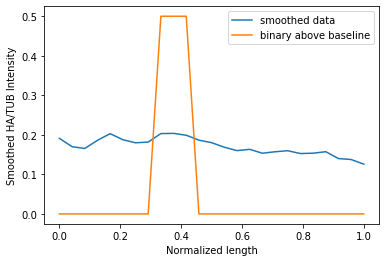

filtered #punc =  1
PDF 2_17_2021_slide_3b_-1_r


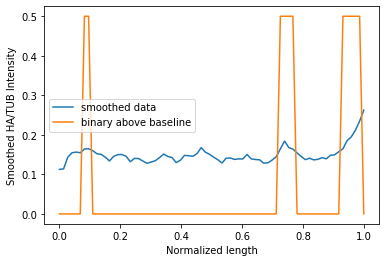

filtered #punc =  3
PDF 2_17_2021_slide_3b_001-1_l


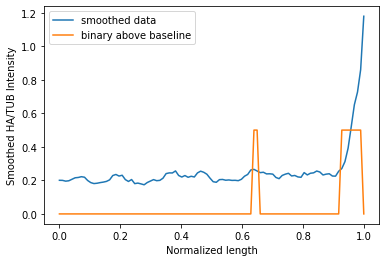

filtered #punc =  2
PDF 2_17_2021_slide_3b_001-1_r


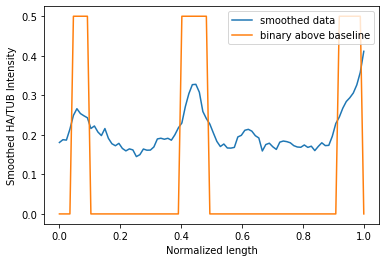

filtered #punc =  3
PDF 3b_3_2_2021_002-1_l


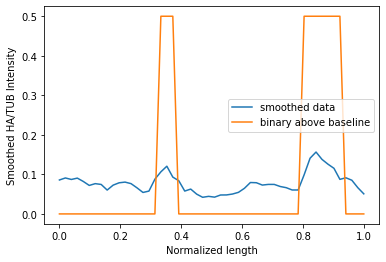

filtered #punc =  2
PDF 3b_3_2_2021_002-1_r


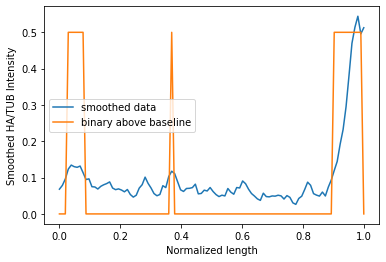

filtered #punc =  2
PDF 3b_3_2_2021_003-1


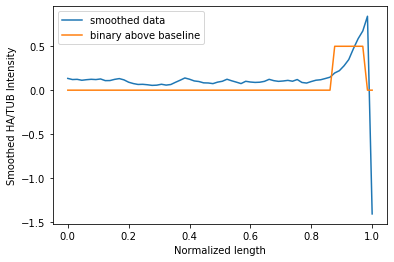

filtered #punc =  1
PDF 3b_slide_2_17_2021_004-1_l


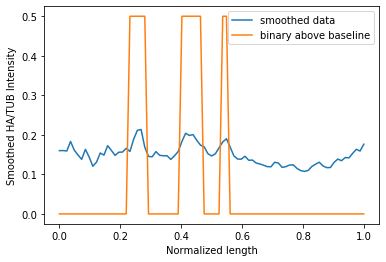

filtered #punc =  3
PDF 3b_slide_2_17_2021_004-1_r


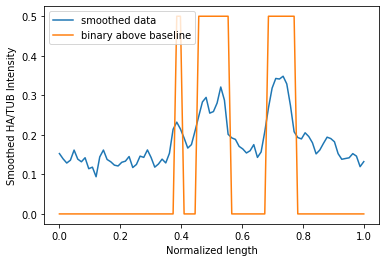

filtered #punc =  3
PDF 3c_slide_2_17_2021_-1


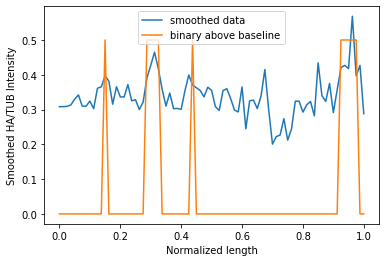

filtered #punc =  2
PDF 3c_slide_2_17_2021_-2


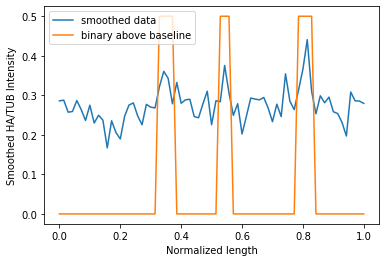

filtered #punc =  3
PDF 3c_slide_2_17_2021_003-1_l


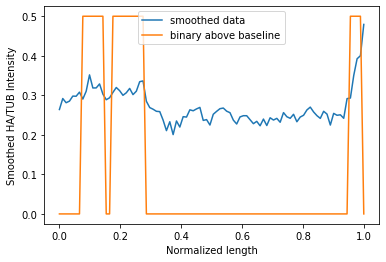

filtered #punc =  3
PDF 3c_slide_2_17_2021_003-1_r


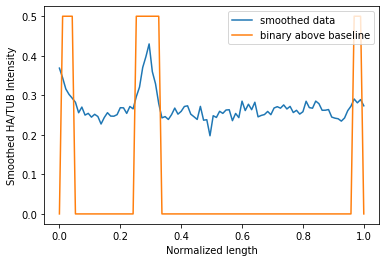

filtered #punc =  3
PDF 3c_slide_2_17_2021_007-1_l


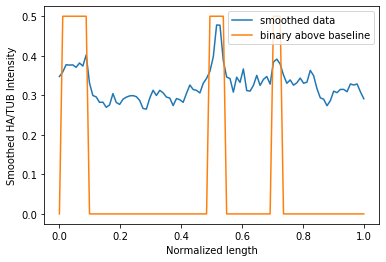

filtered #punc =  3
PDF 3c_slide_2_17_2021_007-1_r


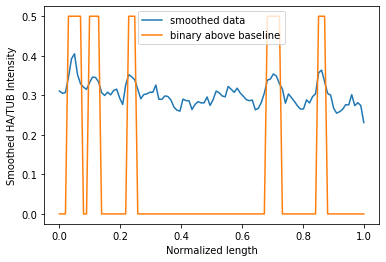

filtered #punc =  5
PDF 3c_slide_2_17_2021_007-2


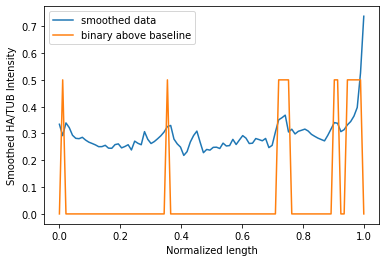

filtered #punc =  3
PDF 3c_slide_2_17_2021_007-3


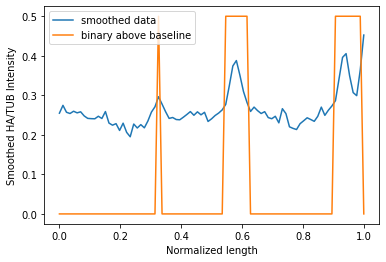

filtered #punc =  2
PDF 3_6_2021_3b_-1_l


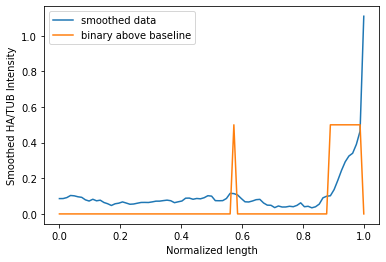

filtered #punc =  1
PDF 3_6_2021_3b_-1_r


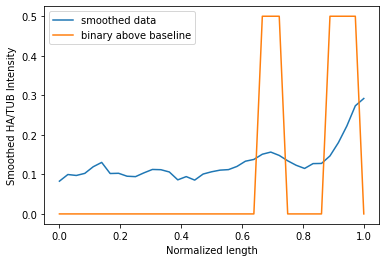

filtered #punc =  2
PDF 3_6_2021_3b_001-1


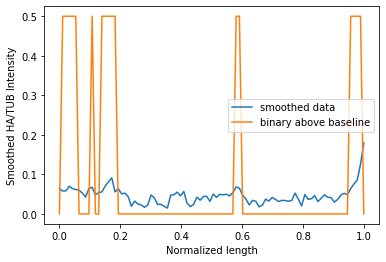

filtered #punc =  4
PDF 4b_2_12_2021_slides_001-1_l


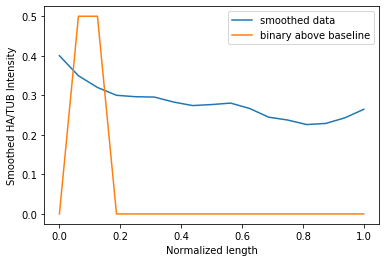

filtered #punc =  1
PDF 4b_2_12_2021_slides_001-1_r


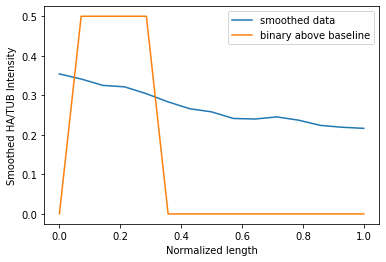

filtered #punc =  1
PDF 4b_2_17_2021_slides_-1


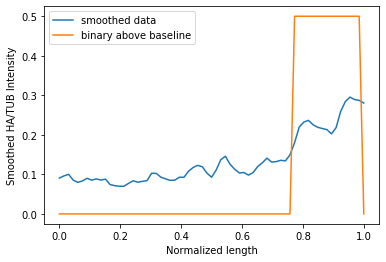

filtered #punc =  1
PDF 4b_2_17_2021_slides_002-1


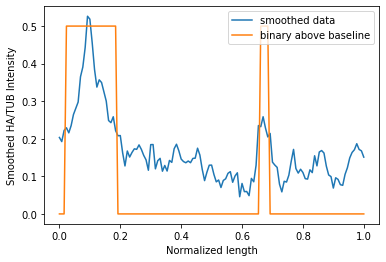

filtered #punc =  2
PDF 4b_2_17_2021_slides_005-1


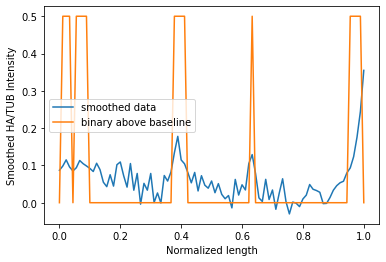

filtered #punc =  4
PDF 4b_3_2_2021_-1


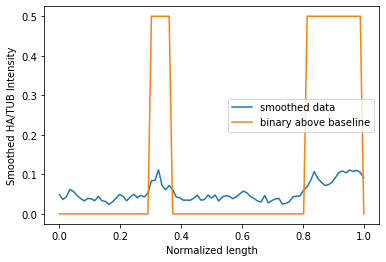

filtered #punc =  2
PDF 4b_3_2_2021_001-1_l


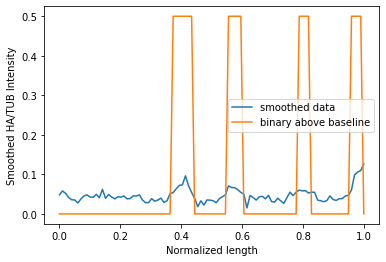

filtered #punc =  4
PDF 4b_3_2_2021_001-1_r


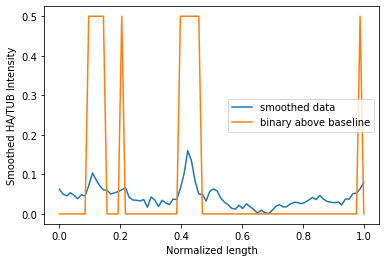

filtered #punc =  3
PDF 4b_3_2_2021_001-2_l


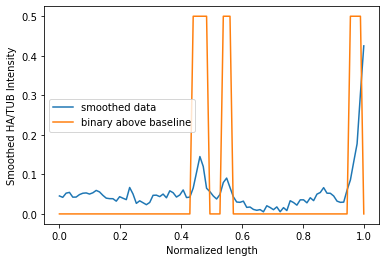

filtered #punc =  3
PDF 4b_3_2_2021_001-2_r


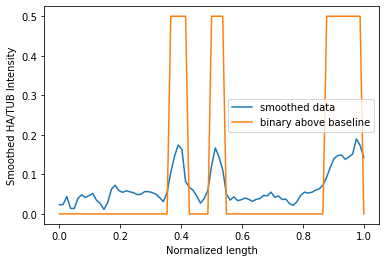

filtered #punc =  3
PDF 4b_3_2_2021_002-1_l


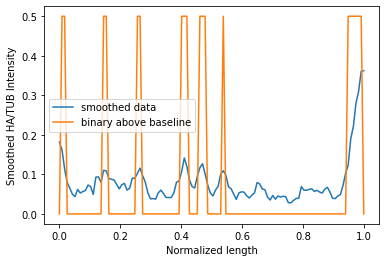

filtered #punc =  6
PDF 4b_3_2_2021_002-1_r


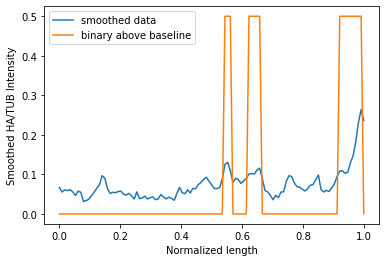

filtered #punc =  3
PDF 4b_3_2_2021_003-1_r


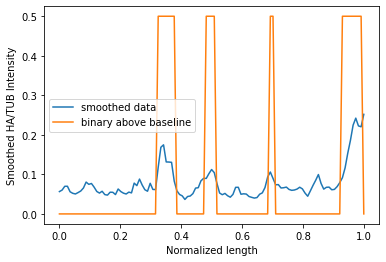

filtered #punc =  4
PDF 4b_3_2_2021_004-1


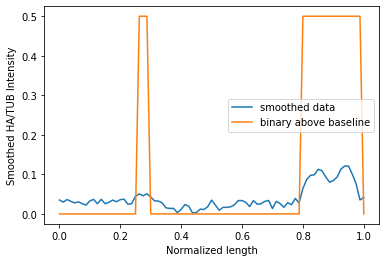

filtered #punc =  2
PDF 4b_3_2_2021_004-2_l


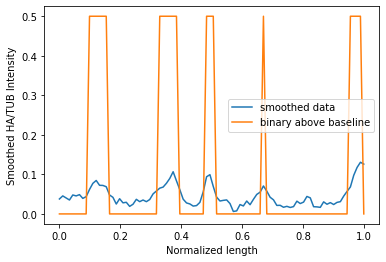

filtered #punc =  4
PDF 4b_3_2_2021_004-2_r


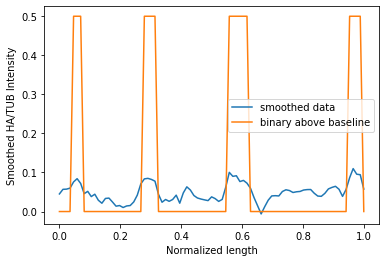

filtered #punc =  4
PDF 4b_3_2_2021_005-1


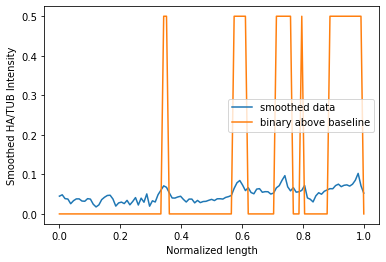

filtered #punc =  4
PDF 4b_3_2_2021_006-1_l


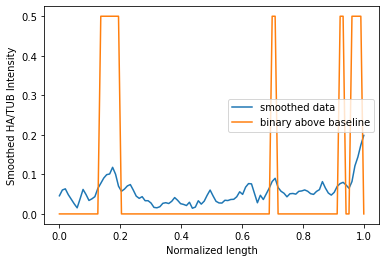

filtered #punc =  4
PDF 4b_3_2_2021_006-1_r


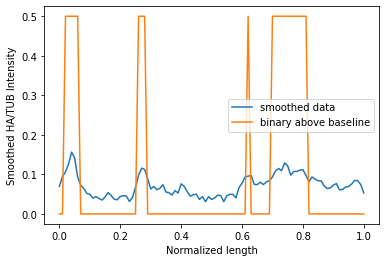

filtered #punc =  3
PDF 4b_3_2_2021_007-1_l


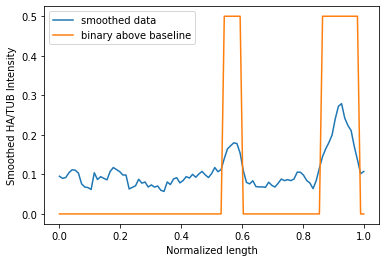

filtered #punc =  2
PDF 4b_3_2_2021_007-1_r


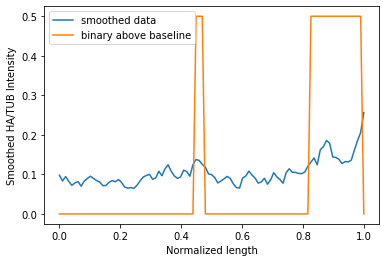

filtered #punc =  2
PDF 4b_3_2_2021_007-2_l


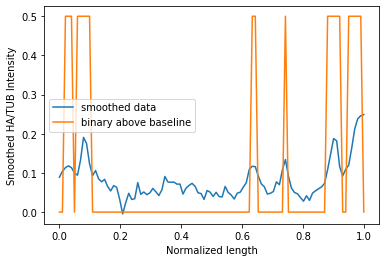

filtered #punc =  5
PDF 4b_3_2_2021_007-2_r


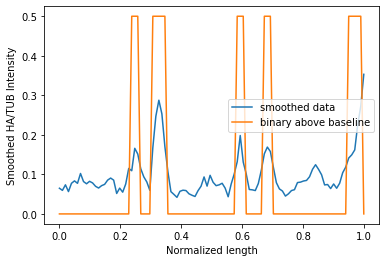

filtered #punc =  5
PDF 4b_3_2_2021_008-1_l


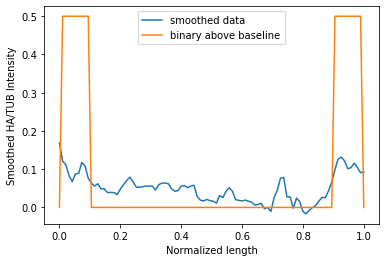

filtered #punc =  2
PDF 4b_3_2_2021_008-1_r


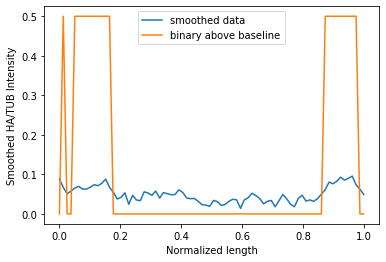

filtered #punc =  2
PDF 4b_3_2_2021_008-2


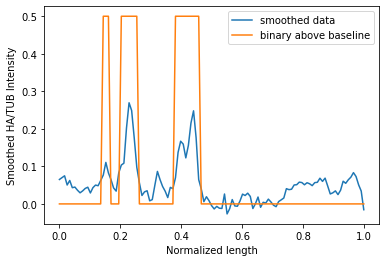

filtered #punc =  3
PDF 4b_3_2_2021_008-3_l


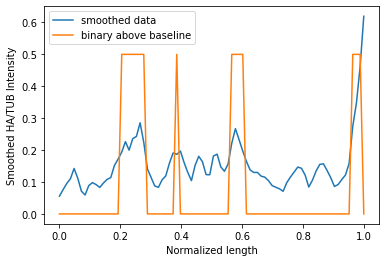

filtered #punc =  3
PDF 4b_3_2_2021_008-3_r


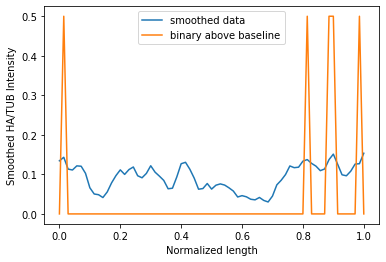

filtered #punc =  2
PDF 4c_2_12_2021_slides_-1


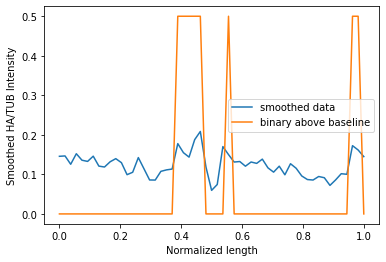

filtered #punc =  2
30 2b_3_9_2021_-1


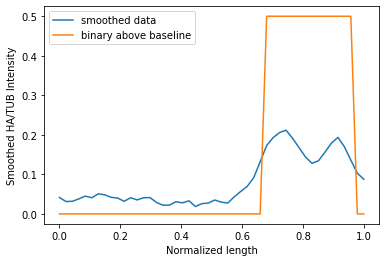

filtered #punc =  1
30 2b_3_9_2021_001-1


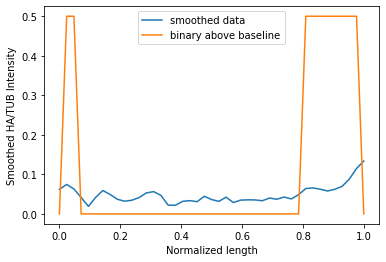

filtered #punc =  2
30 2b_3_9_2021_001-2


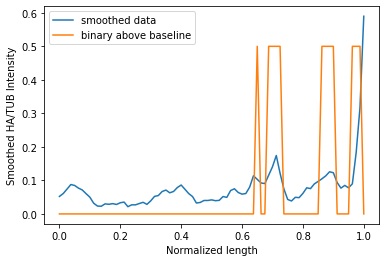

filtered #punc =  3
30 2b_3_9_2021_001-3


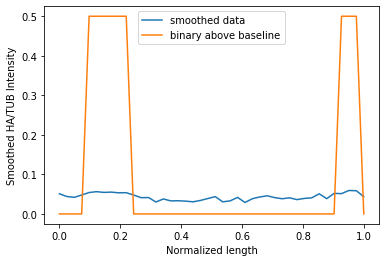

filtered #punc =  2
30 2b_3_9_2021_002-1_l


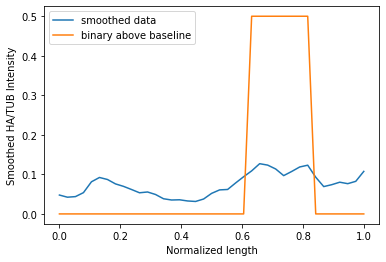

filtered #punc =  1
30 2b_3_9_2021_002-1_r


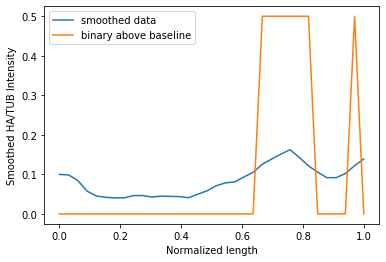

filtered #punc =  2
30 2b_3_9_2021_002-2


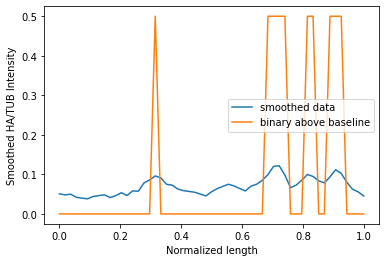

filtered #punc =  3
30 2b_3_9_2021_002-3


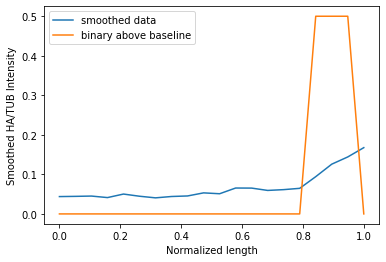

filtered #punc =  1
30 2b_3_9_2021_003-1_l


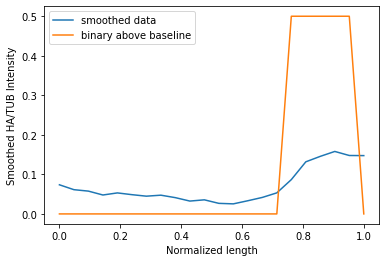

filtered #punc =  1
30 2b_3_9_2021_003-1_r


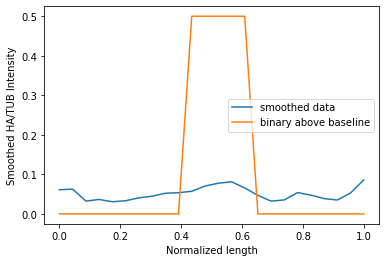

filtered #punc =  1
30 2b_3_9_2021_004-1


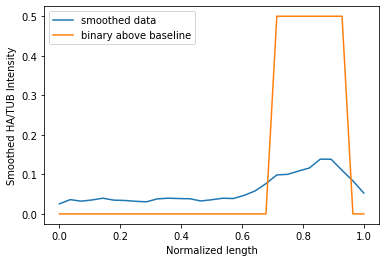

filtered #punc =  1
30 2b_3_9_2021_005-1


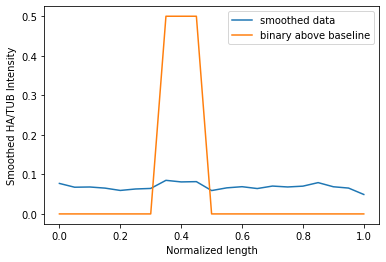

filtered #punc =  1
30 2b_3_9_2021_005-2


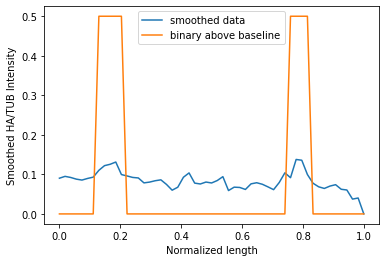

filtered #punc =  2
30 2b_3_9_2021_005-3


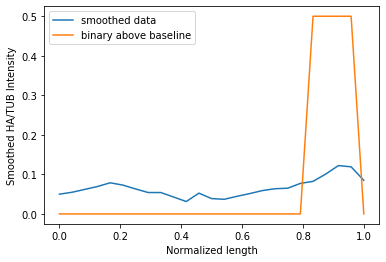

filtered #punc =  1
30 3_6_2021_1b_-1_l


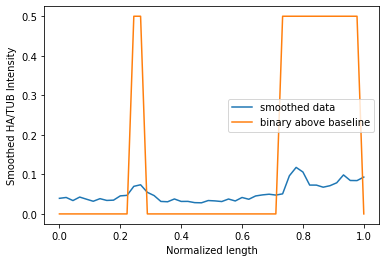

filtered #punc =  2
30 3_6_2021_1b_-1_r


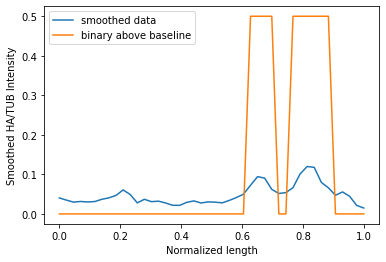

filtered #punc =  2
30 3_6_2021_1b_001-1_l


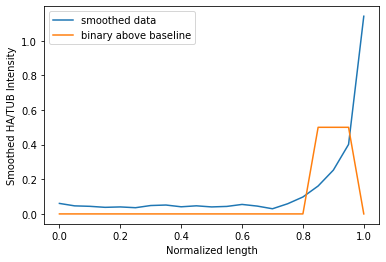

filtered #punc =  1
30 3_6_2021_1b_001-1_r


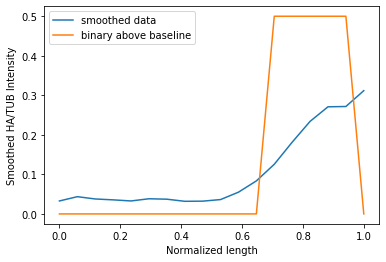

filtered #punc =  1
30 3_6_2021_1b_002-1


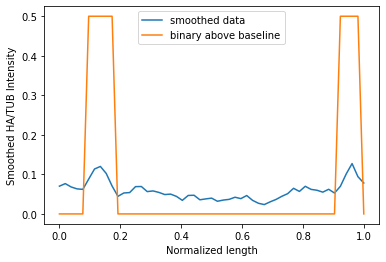

filtered #punc =  2
30 3_6_2021_1b_003-1_l


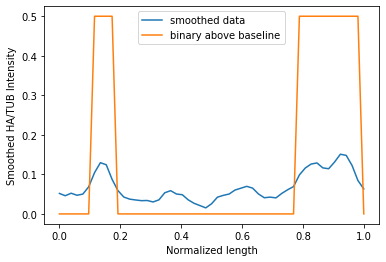

filtered #punc =  2
30 3_6_2021_1b_003-1_r


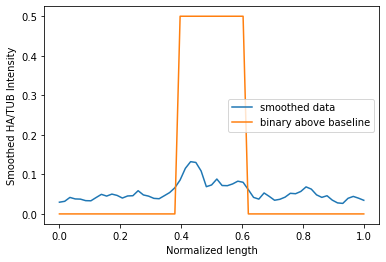

filtered #punc =  1
30 3_6_2021_1b_003-2_l


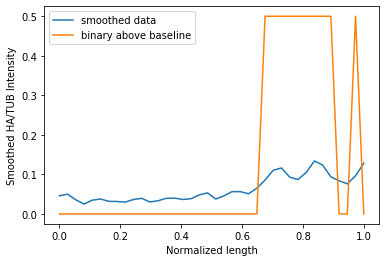

filtered #punc =  2
30 3_6_2021_1b_003-2_r


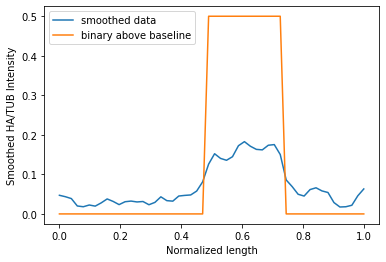

filtered #punc =  1
30 3_6_2021_1b_003-3


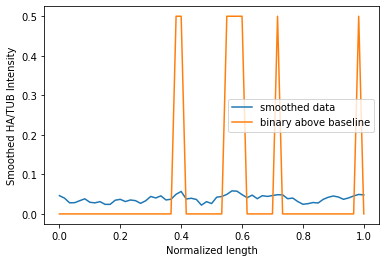

filtered #punc =  3
30 3_6_2021_1b_004-1_l


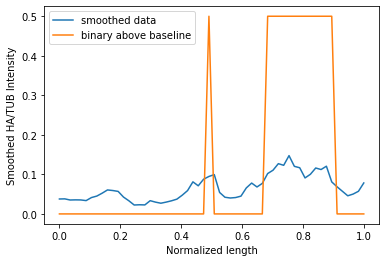

filtered #punc =  1
30 3_6_2021_1b_004-1_r


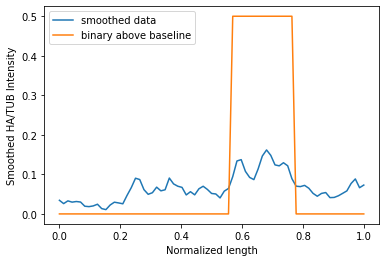

filtered #punc =  1
30 3_6_2021_1b_004-2


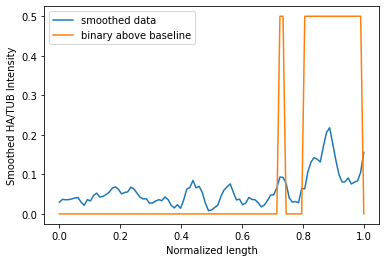

filtered #punc =  2
30 3_6_2021_1b_005-1


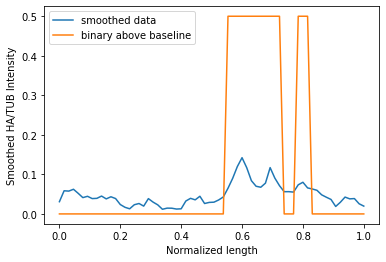

filtered #punc =  2
30 3_6_2021_1b_005-2_l


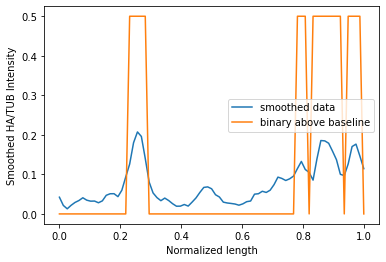

filtered #punc =  4
30 3_6_2021_1b_005-2_r


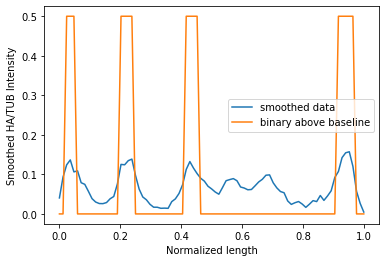

filtered #punc =  4
30 3_6_2021_1b_005-3_l


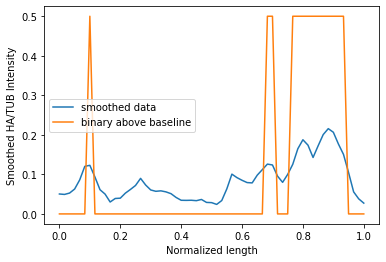

filtered #punc =  2
30 3_6_2021_1b_005-3_r


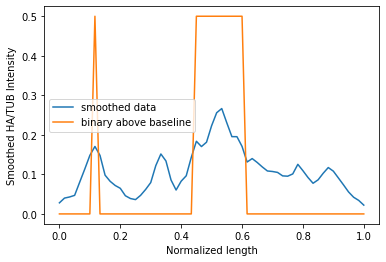

filtered #punc =  1
30 slide_1b_2_17_2021_004-1_l


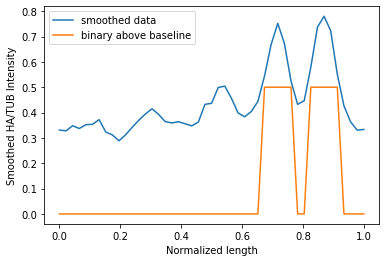

filtered #punc =  2
30 slide_1b_2_17_2021_004-1_r


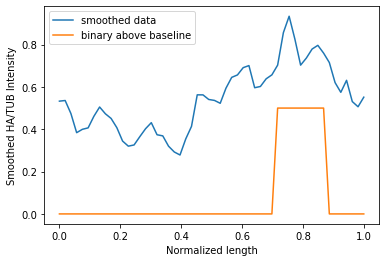

filtered #punc =  1
30 slide_1b_2_17_2021_005-1_l


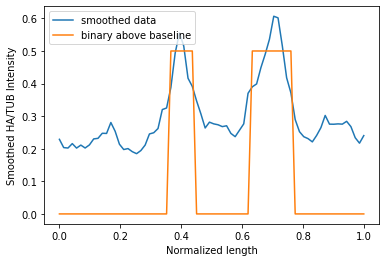

filtered #punc =  2
30 slide_1b_2_17_2021_005-1_r


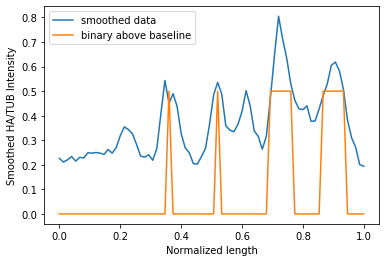

filtered #punc =  2
30 slide_1b_2_17_2021_005-2


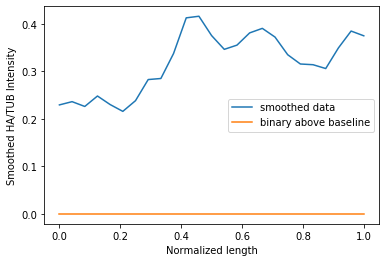

filtered #punc =  0
30 slide_1b_2_17_2021_005-3


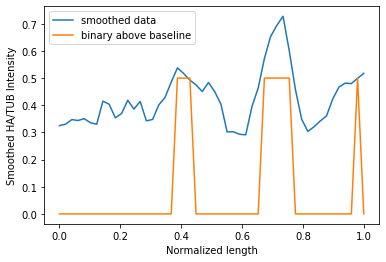

filtered #punc =  3
30 slide_1b_2_17_2021_005-4


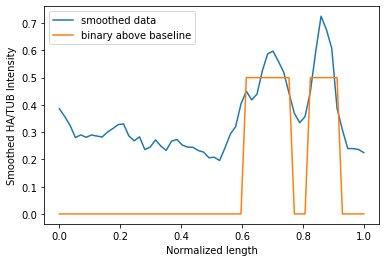

filtered #punc =  2
30 slide_1b_2_17_2021_005-5


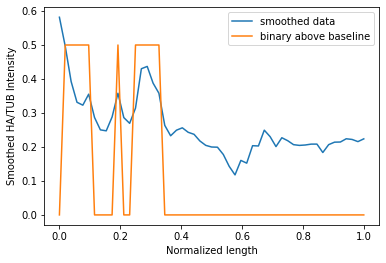

filtered #punc =  2
30 slide_1b_2_17_2021_006-1


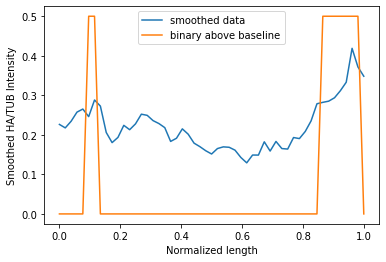

filtered #punc =  2
30 slide_1b_2_17_2021_006-2_l


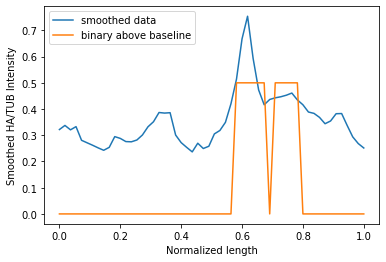

filtered #punc =  2
30 slide_1b_2_17_2021_006-2_r


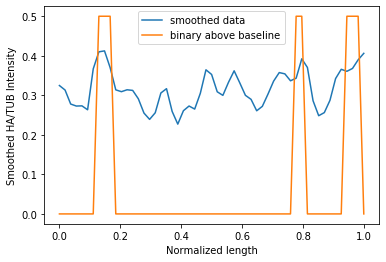

filtered #punc =  3
30 slide_1b_2_17_2021_006-3


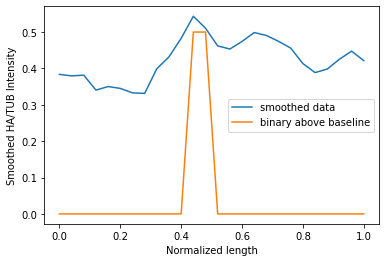

filtered #punc =  1
30 slide_1b_2_17_2021_007-1


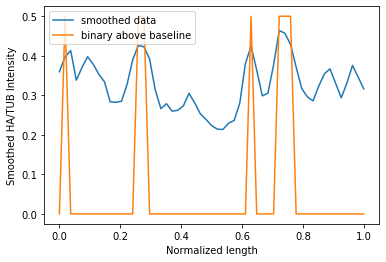

filtered #punc =  2
30 slide_1b_2_17_2021_008-1


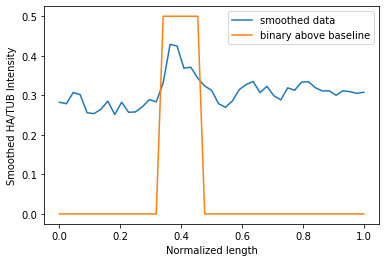

filtered #punc =  1
30 slide_1b_2_17_2021_008-2


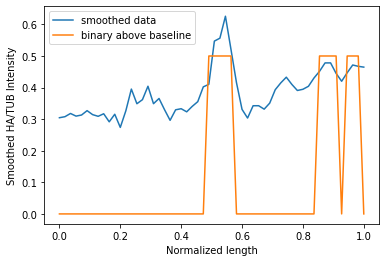

filtered #punc =  3
30 slide_1b_2_17_2021_008-3


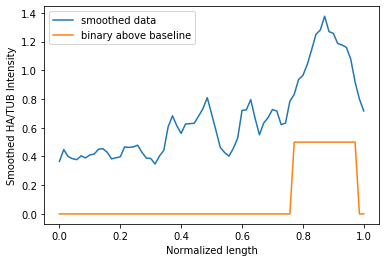

filtered #punc =  1
30 slide_1b_2_17_2021_008-4


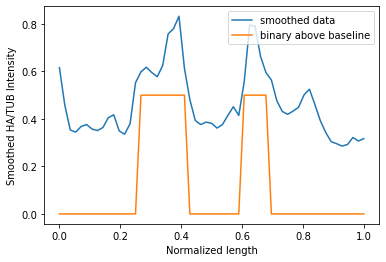

filtered #punc =  2
30 slide_1b_2_17_2021_008-5


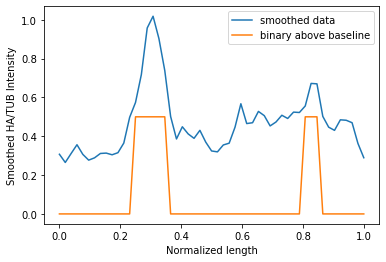

filtered #punc =  2
30 slide_1b_2_17_2021_009-1_l


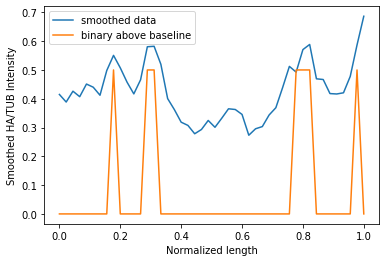

filtered #punc =  3
30 slide_1b_2_17_2021_009-1_r


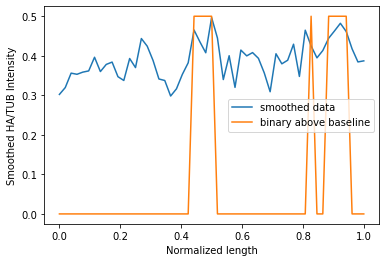

filtered #punc =  2
30 slide_1b_2_17_2021_009-2


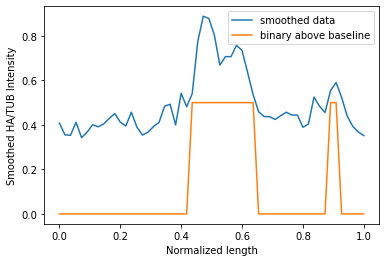

filtered #punc =  2
30 slide_1b_2_17_2021_009-3_l


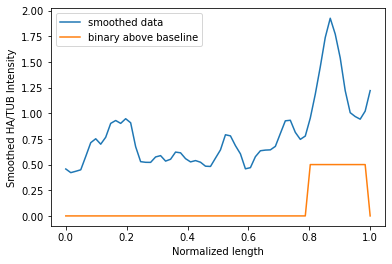

filtered #punc =  1
30 slide_1b_2_17_2021_009-3_r


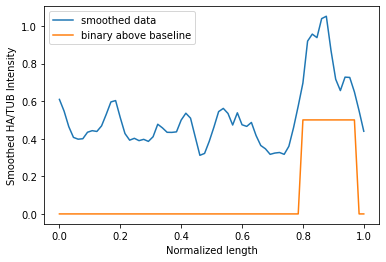

filtered #punc =  1
30 slide_1c_2_17_2021_001-1


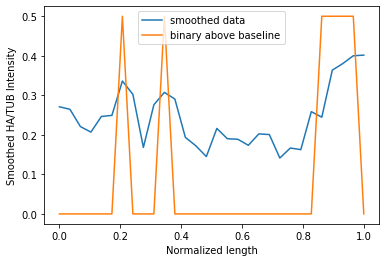

filtered #punc =  1
30 slide_1c_2_17_2021_001-2_l


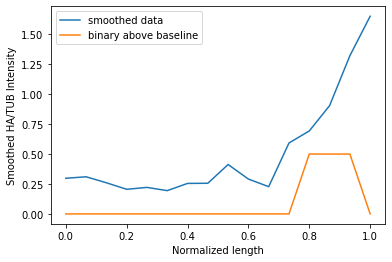

filtered #punc =  1
30 slide_1c_2_17_2021_001-2_r


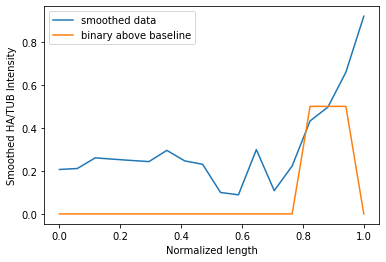

filtered #punc =  1
30 slide_1c_2_17_2021_002-1


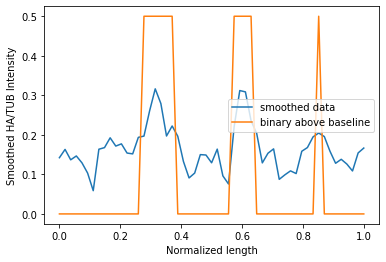

filtered #punc =  2
30 slide_1c_2_17_2021_002-3


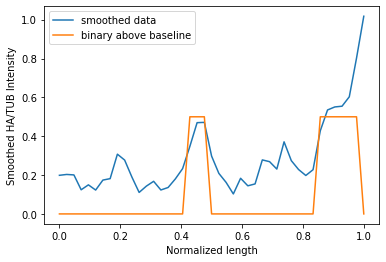

filtered #punc =  2
30 slide_1c_2_17_2021_003-1


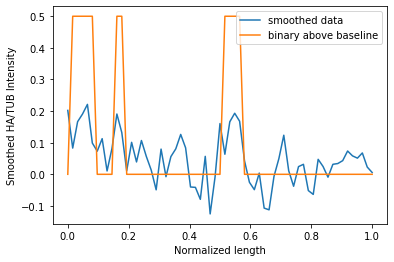

filtered #punc =  3
30 slide_1c_2_17_2021_003-2_l


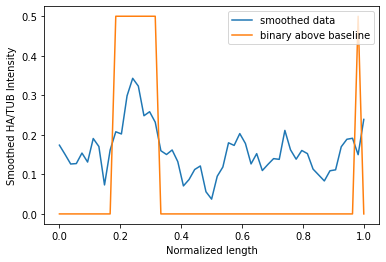

filtered #punc =  2
30 slide_1c_2_17_2021_003-2_r


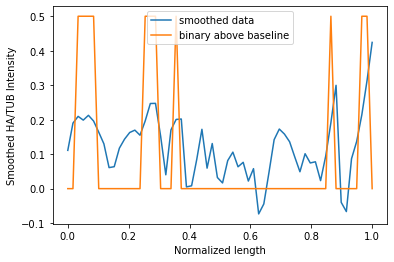

filtered #punc =  3
30 slide_1c_2_17_2021_003-3


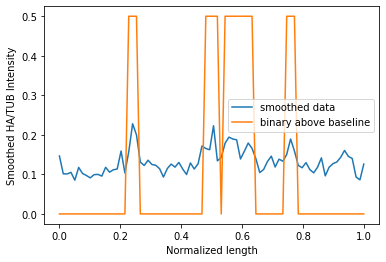

filtered #punc =  4
30 slide_1c_2_17_2021_003-4


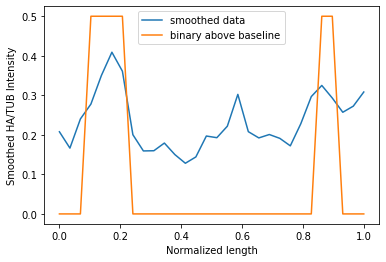

filtered #punc =  2
30 slide_1c_2_17_2021_003-5


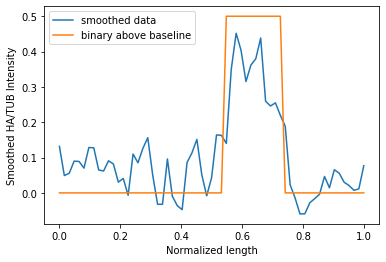

filtered #punc =  1
30 slide_1c_2_17_2021_003-6


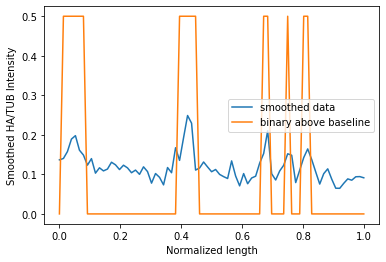

filtered #punc =  4
30 slide_1c_2_17_2021_003-7


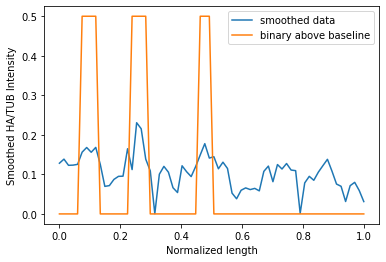

filtered #punc =  3
30 slide_1c_2_17_2021_003-8


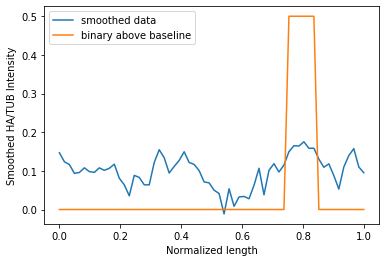

filtered #punc =  1
30 slide_1c_2_17_2021_005-1


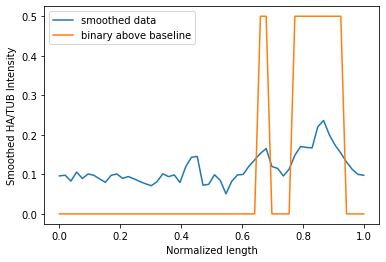

filtered #punc =  2
30 slide_1c_2_17_2021_005-2


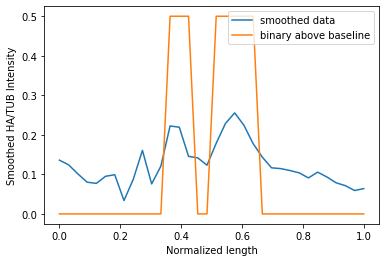

filtered #punc =  2
30 slide_1c_2_17_2021_005-3


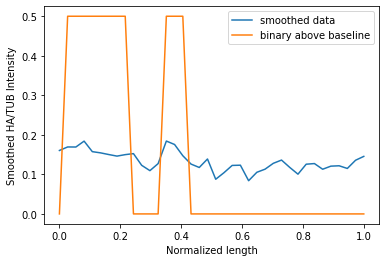

filtered #punc =  2
30 slide_1c_2_17_2021_005-4


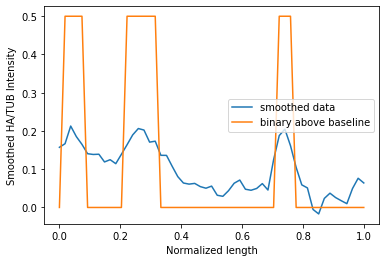

filtered #punc =  3
30 slide_2b_2_17_21_-1


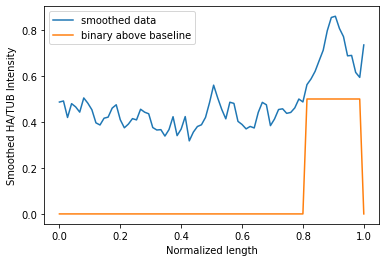

filtered #punc =  1
30 slide_2b_2_17_21_007-1


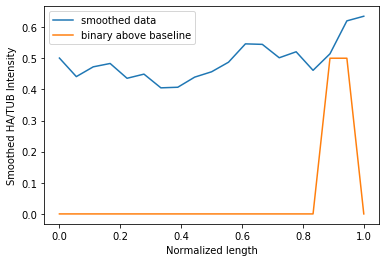

filtered #punc =  1
30 slide_2b_2_17_21_010-1


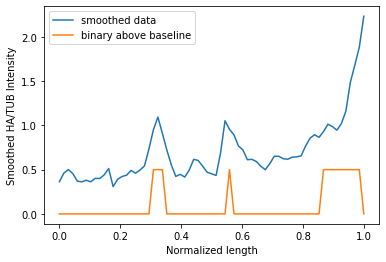

filtered #punc =  2
30 slide_2c_2_17_21_001-1_l


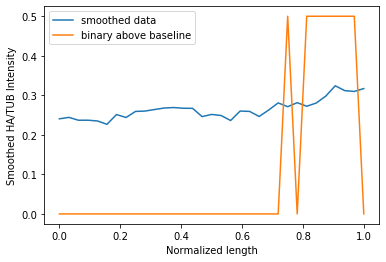

filtered #punc =  1
30 slide_2c_2_17_21_003-1_r


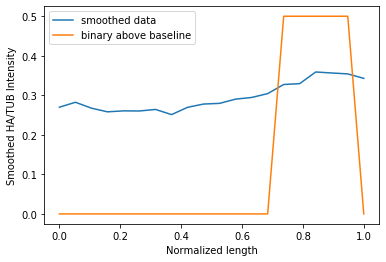

filtered #punc =  1
60 6b_2_17_2021_slides_001-1


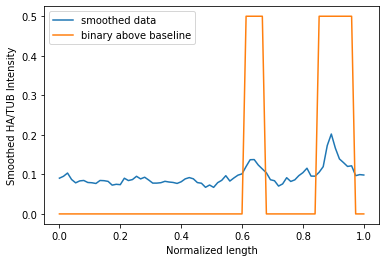

filtered #punc =  2
60 6c_2_17_2021_slides_004-1


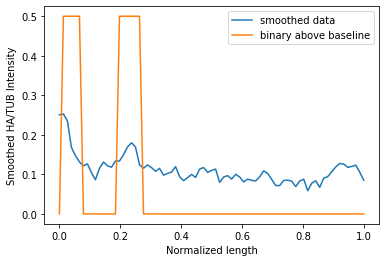

filtered #punc =  2
60 6c_2_17_2021_slides_004-2


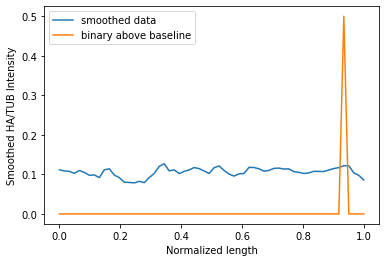

filtered #punc =  0
60 6c_2_17_2021_slides_004-3


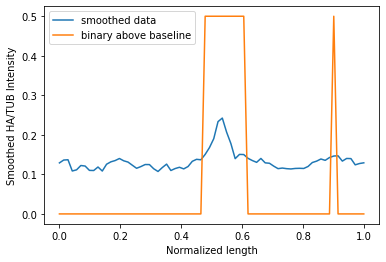

filtered #punc =  1
60 6c_2_17_2021_slides_006-1_l


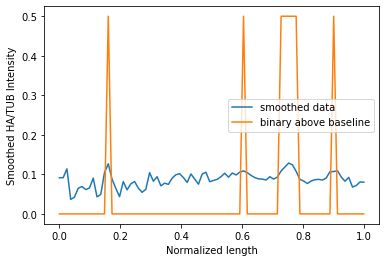

filtered #punc =  1
60 6c_2_17_2021_slides_006-1_r


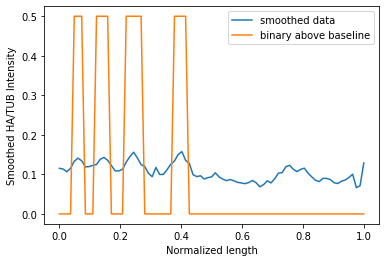

filtered #punc =  4
60 slide_6b_2_17_21_001-1


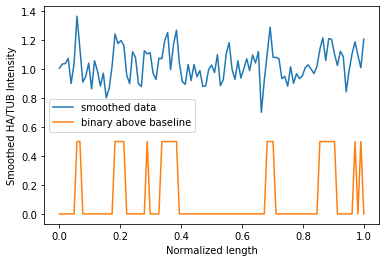

filtered #punc =  6


In [131]:
## ANALYSIS including puncta detection
# take in data for each flagellum
# process for general analysis & puncta detection
# output : 
# 1) analysis file - columns are metrics; rows are flagella, sheets are conditions
# columns: flagID, length avg (HA/TUB, HA, TUB), std (HA/TUB, HA, TUB), puncta metrics
# 2) puncta detection file - columns are puncta, rows are metrics, sheets are flagella

results_dir = 'C:/Users/Mary/Documents/Shared folder/Karina/HA in Flagella/Sum Slices data'
linescan_data = pd.read_excel(results_dir + "/all_linescans_preprocessed.xlsx", sheet_name = None)
flagellaIDs = list(linescan_data.keys()) # all filenames are sheet names in linescan_data
num_sheets = len(flagellaIDs)

# number-letter identifiers for each condition :
# PDF (predeflagellation), 30 (30-min regeneration), 60 (60-min regeneration)
ID_PDF = ['PDF','3b','3c','4b','4c']
ID_30 = ['30','1b','1c','2b','2c']
ID_60 = ['60','5b','5c','6b','6c']
conditions = [ID_PDF, ID_30, ID_60]

puncta_detect_xl = pd.ExcelWriter("puncta_detection.xlsx", engine='xlsxwriter')
analysis = pd.ExcelWriter("flagella_metrics.xlsx", engine='xlsxwriter')
puncta_analysis = pd.ExcelWriter("puncta_analysis.xlsx", engine='xlsxwriter')

for ID in conditions:
    analysis_df = pd.DataFrame()  # 1 dataframe per condition (ID)
    puncta_analysis_df = pd.DataFrame()

    flag_ID = []
    length = []
    mean_int_HA_TUB = []
    mean_int_HA = []
    mean_int_TUB = []
    std_int_HA_TUB = []
    std_int_HA = []
    std_int_TUB = []
    num_puncta = []
    tip_enrichmt = []
    
    pc_flagella = []
    pc = []
    pc_mean_int = []
    pc_std_int = []
    pc_size_um = []
    pc_size_pts = []
    pc_centroid_norm = []
    pc_centroid_raw = []
    pc_max_norm_pos = []
    pc_max_raw_pos = []
    pc_max_int = []
    pc_mean_enrich = []
    pc_max_enrich = []
    
    for sheet in linescan_data:
        if any(item in sheet for item in ID):
            print(ID[0],sheet)
            flag_ID.append(sheet)

            # import columns
            HA = linescan_data[sheet]['HA BgSub AS']
            TUB = linescan_data[sheet]['TUB BgSub AS']
            HA_TUB = linescan_data[sheet]['HA/TUB AS']
            sm_HA_TUB = linescan_data[sheet]['Smoothed HA/TUB AS']
            raw_x = linescan_data[sheet]['x']
            norm_x = linescan_data[sheet]['Norm x']

            # general analysis
        #     len_col = int(raw_x[sheet][0])
            flag_length = raw_x[len(raw_x)-1]
            length.append(flag_length)

            HA_mean = HA.describe()[1]
            TUB_mean = TUB.describe()[1]
            HA_TUB_mean = HA_TUB.describe()[1]
            mean_int_HA_TUB.append(HA_TUB_mean)
            mean_int_HA.append(HA_mean)
            mean_int_TUB.append(TUB_mean)

            HA_std = HA.describe()[2]
            TUB_std = TUB.describe()[2]
            HA_TUB_std = HA_TUB.describe()[2]
            std_int_HA_TUB.append(HA_TUB_std)
            std_int_HA.append(HA_std)
            std_int_TUB.append(TUB_std)
            
            # puncta detection & analysis
            # perform tip puncta analysis on HA/TUB
            # perform puncta analysis in distal flagellum on HA
            puncta = puncta_detection(norm_x,raw_x,HA_TUB,HA_TUB_mean,HA_TUB_std,linescan_data,sheet)            
            
            if puncta[0] :
                puncta[1].to_excel(puncta_detect_xl,sheet_name=sheet,index=False)
                num_puncta.append(puncta[2])
                tip_enrichmt.append(puncta[3]) # tip enrichment
                
                for pctm in puncta[1]:
                    if 'Punctum' in pctm:
#                         print(pctm)
                        pc_flagella.append(sheet)
                        pc.append(pctm)
                        pc_mean_int.append(puncta[1][pctm][9])
                        pc_std_int.append(puncta[1][pctm][10])
                        pc_size_um.append(puncta[1][pctm][4])
                        pc_size_pts.append(puncta[1][pctm][5])
                        pc_centroid_norm.append(puncta[1][pctm][7])
                        pc_centroid_raw.append(puncta[1][pctm][6])
                        pc_max_norm_pos.append(puncta[1][pctm][13])
                        pc_max_raw_pos.append(puncta[1][pctm][12])
                        pc_max_int.append(puncta[1][pctm][11])
                        pc_mean_enrich.append(puncta[1][pctm][14])
                        pc_max_enrich.append(puncta[1][pctm][15])

            else:
                num_puncta.append(puncta[1])
                tip_enrichmt.append(puncta[2]) # tip enrichment
                

#     print(flag_ID)
#     print(tip_enrichmt)
    
    analysis_df['Flagellum'] = flag_ID
    analysis_df['Length'] = length
    analysis_df['Mean - HA/TUB'] = mean_int_HA_TUB
    analysis_df['Stdev - HA/TUB'] = std_int_HA_TUB
    analysis_df['Mean - HA'] = mean_int_HA
    analysis_df['Stdev - HA'] = std_int_HA
    analysis_df['Mean - TUB'] = mean_int_TUB
    analysis_df['Stdev - TUB'] = std_int_TUB
    analysis_df['# Puncta'] = num_puncta
    analysis_df['Tip Enrichment'] = tip_enrichmt
    
    analysis_df.to_excel(analysis,sheet_name=ID[0],index=False)
    
    puncta_analysis_df['Flagellum'] = pc_flagella
    puncta_analysis_df['Punctum'] = pc
    puncta_analysis_df['Mean HA/TUB'] = pc_mean_int
    puncta_analysis_df['Stdev HA/TUB'] = pc_std_int 
    puncta_analysis_df['Size (um)'] = pc_size_um 
    puncta_analysis_df['Size (pts)'] = pc_size_pts 
    puncta_analysis_df['Centroid position (norm)'] = pc_centroid_norm 
    puncta_analysis_df['Centroid position (raw)'] = pc_centroid_raw 
    puncta_analysis_df['Max position (norm)'] = pc_max_norm_pos 
    puncta_analysis_df['Max position (raw)'] = pc_max_raw_pos 
    puncta_analysis_df['Max intensity'] = pc_max_int 
    puncta_analysis_df['Mean enrichmt > baseline'] = pc_mean_enrich
    puncta_analysis_df['Max enrichmt > baseline'] = pc_max_enrich
    puncta_analysis_df.to_excel(puncta_analysis,sheet_name=ID[0],index=False)

# print(analysis_df)
# os.chdir(results_dir)
# analysis.save()
# puncta_detect_xl.save()
# puncta_analysis.save()
    


In [ ]:
# 2. new dataframe w cumulative norm curves, statistics
all_norm = pd.DataFrame()
all_norm_PDF = pd.DataFrame()
all_norm_30m = pd.DataFrame()
all_norm_60m = pd.DataFrame()
all_norm_cols = []
all_norm_cols_PDF = []
all_norm_cols_30m = []
all_norm_cols_60m = []
all_norm_header = []
all_norm_header_PDF = []
all_norm_header_30m = []
all_norm_header_60m = []

results_dir = 'C:/Users/Mary/Documents/Shared folder/Karina/HA in Flagella/Sum Slices data'
#os.chdir(results_dir)
flagella_data = pd.read_excel(results_dir + "/all_linescans_preprocessed", sheet_name = None)
flagellaIDs = list(flagella_data.keys())
num_sheets = len(flagellaIDs)
#overlayplot = figure()
color = ''
condition = ''
PDF = ['3b','3c','4b','4c']
regen30 = ['1b','1c','2b','2c']
regen60 = ['5b','5c','6b','6c']

for sheet in flagella_data:

#loop through sheets in xlsx file, pull out last column, add to analysis

    #print(i)
#     x_header = "x_" + sheet
#     all_norm_header.append(x_header)
    flag_norm_x = flag_data['Norm x']
    all_norm_cols.append(flag_norm_x)
    #print(x_header)
    #print(int_header)
    #print(all_norm[col_x])
    
#     int_header = "int_" + sheet
#     all_norm_header.append(int_header)
    sm_HA-TUB = all_linescans[sheet]['Smoothed HA/TUB AS']
    rawdata = all_linescans[sheet]['HA/TUB AS']
    raw_x = all_linescans[sheet]['x']
    norm_x = all_linescans[sheet]['Norm x']
    data_dscr = data.describe()
    print(dscr)
    data_avg = data_dscr[1]
    data_std = data_dscr[2]
    
    flag_norm_int = flag_data['HA/TUB AS']
    all_norm_cols.append(flag_norm_int)
    
    TUB_header = "TUB_" + sheet
    all_norm_header.append(TUB_header)
    flag_norm_TUB = flag_data['TUB BgSub AS']
    all_norm_cols.append(flag_norm_TUB)
    
    HA_header = "HA_" + sheet
    all_norm_header.append(HA_header)
    flag_norm_HA = flag_data['HA BgSub AS']
    all_norm_cols.append(flag_norm_HA)
    
    for x in PDF:
        if x in sheet:
            all_norm_header_PDF.append(x_header)
            all_norm_cols_PDF.append(flag_norm_x)
            all_norm_header_PDF.append(int_header)
            all_norm_cols_PDF.append(flag_norm_int)
            all_norm_header_PDF.append(TUB_header)
            all_norm_cols_PDF.append(flag_norm_TUB)
            all_norm_header_PDF.append(HA_header)
            all_norm_cols_PDF.append(flag_norm_HA)

            color = 'black'
            condition = 'PDF'
    for x in regen30:
        if x in sheet:
            all_norm_header_30m.append(x_header)
            all_norm_header_30m.append(int_header)
            all_norm_cols_30m.append(flag_norm_x)
            all_norm_cols_30m.append(flag_norm_int)
            all_norm_header_30m.append(TUB_header)
            all_norm_cols_30m.append(flag_norm_TUB)
            all_norm_header_30m.append(HA_header)
            all_norm_cols_30m.append(flag_norm_HA)

            color = 'red'
            condition = '30m'
    for x in regen60:
        if x in sheet:
            all_norm_header_60m.append(x_header)
            all_norm_header_60m.append(int_header)
            all_norm_cols_60m.append(flag_norm_x)
            all_norm_cols_60m.append(flag_norm_int)
            all_norm_header_60m.append(TUB_header)
            all_norm_cols_60m.append(flag_norm_TUB)
            all_norm_header_60m.append(HA_header)
            all_norm_cols_60m.append(flag_norm_HA)

            color = 'blue'
            condition = '60m'
    
    #print(condition)

     # overlay plot with all normalized curves
    #plt.plot(flag_norm_x,flag_norm_int, label = i, c=color, alpha = 0.5)
    #plt.legend()
    
all_norm = pd.concat(all_norm_cols, axis = 1)
all_norm.columns = all_norm_header
all_norm.to_excel("all_normalized_flagella.xlsx",sheet_name = 'all', index=False)

#output = pd.ExcelWriter("all_normalized_prelim.xlsx", engine='xlsxwriter')
all_norm_PDF = pd.concat(all_norm_cols_PDF, axis = 1)
all_norm_PDF.columns = all_norm_header_PDF
all_norm_PDF.to_excel("all_normalized_flagella_PDF.xlsx",sheet_name = 'PDF', index=False)

all_norm_30m = pd.concat(all_norm_cols_30m, axis = 1)
all_norm_30m.columns = all_norm_header_30m
all_norm_30m.to_excel("all_normalized_flagella_30m.xlsx",sheet_name = '30m', index=False)

all_norm_60m = pd.concat(all_norm_cols_60m, axis = 1)
all_norm_60m.columns = all_norm_header_60m
all_norm_60m.to_excel("all_normalized_flagella_60m.xlsx",sheet_name = '60m', index=False)


In [580]:
# 3. pool results for analysis into 1 cumulative file
# can rewrite this using a function
analysis_xlsx = pd.read_excel(results_dir + "/all_norm_analysis.xlsx", sheet_name = None)
analysis_xlsx_PDF  = pd.read_excel(results_dir + "/all_norm_analysis.xlsx", sheet_name = "PDF")
analysis_xlsx_30m = pd.read_excel(results_dir + "/all_norm_analysis.xlsx", sheet_name = "30m")
analysis_xlsx_60m = pd.read_excel(results_dir + "/all_norm_analysis.xlsx", sheet_name = "60m")
conditions = ['PDF','30m','60m']
intensity_cols = ['int','TUB','HA']

# cumulative analysis
cumulative = pd.DataFrame()
header = []
cols = []

for i in conditions:
    data  = pd.read_excel(results_dir + "/all_norm_analysis.xlsx", sheet_name = i)
    cols.append(data["Length"])
    header.append("Length_" + i)
for j in intensity_cols:
    for i in conditions:
        data  = pd.read_excel(results_dir + "/all_norm_analysis.xlsx", sheet_name = i)
        cols.append(data["Mean " + j])
        header.append("Mean_" + j + " " + i)
for j in intensity_cols:
    for i in conditions:
        data  = pd.read_excel(results_dir + "/all_norm_analysis.xlsx", sheet_name = i)
        cols.append(data["max " + j])
        header.append("Max_" + j + " " + i)
for j in intensity_cols:
    for i in conditions:
        data  = pd.read_excel(results_dir + "/all_norm_analysis.xlsx", sheet_name = i)
        cols.append(data['max loc ' + j])
        header.append("Max_Loc_" + j + " " + i)
for j in intensity_cols:
    for i in conditions:
        data  = pd.read_excel(results_dir + "/all_norm_analysis.xlsx", sheet_name = i)
        cols.append(data["stdev " + j])
        header.append("Stdev_" + j + " " + i)
for j in intensity_cols:
    for i in conditions:
        data  = pd.read_excel(results_dir + "/all_norm_analysis.xlsx", sheet_name = i)
        cols.append(data["# pts above 1 std " + j])
        header.append("# >1std_" + j + " " + i)
for j in intensity_cols:
    for i in conditions:
        data  = pd.read_excel(results_dir + "/all_norm_analysis.xlsx", sheet_name = i)
        cols.append(data["% above 1 std " + j])
        header.append("% >1std_" + j + " " + i)
for j in intensity_cols:
    for i in conditions:
        data  = pd.read_excel(results_dir + "/all_norm_analysis.xlsx", sheet_name = i)
        cols.append(data["Avg Last 25% " + j])
        header.append("Last 25%_" + j + " " + i)
for j in intensity_cols:
    for i in conditions:
        data  = pd.read_excel(results_dir + "/all_norm_analysis.xlsx", sheet_name = i)
        cols.append(data["# pts above 1 std " + j + "_25"])
        header.append("# >1std_25_" + j + " " + i)
for j in intensity_cols:
    for i in conditions:
        data  = pd.read_excel(results_dir + "/all_norm_analysis.xlsx", sheet_name = i)
        cols.append(data["% above 1 std " + j + "_25"])
        header.append("% >1std_25_" + j + " " + i)
for j in intensity_cols:
    for i in conditions:
        data  = pd.read_excel(results_dir + "/all_norm_analysis.xlsx", sheet_name = i)
        cols.append(data["Avg Last 10% " + j])
        header.append("Last 10%_" + j + " " + i)
for j in intensity_cols:
    for i in conditions:
        data  = pd.read_excel(results_dir + "/all_norm_analysis.xlsx", sheet_name = i)
        cols.append(data["# pts above 1 std " + j + "_10"])
        header.append("# >1std_" + j + " " + i)
for j in intensity_cols:
    for i in conditions:
        data  = pd.read_excel(results_dir + "/all_norm_analysis.xlsx", sheet_name = i)
        cols.append(data["% above 1 std " + j + "_10"])
        header.append("% >1std_" + j + " " + i)
for j in intensity_cols:
    for i in conditions:
        data  = pd.read_excel(results_dir + "/all_norm_analysis.xlsx", sheet_name = i)
        cols.append(data["Avg Last 5% " + j])
        header.append("Last 5%_" + j + " " + i)
for j in intensity_cols:
    for i in conditions:
        data  = pd.read_excel(results_dir + "/all_norm_analysis.xlsx", sheet_name = i)
        cols.append(data["# pts above 1 std " + j + "_5"])
        header.append("# >1std_" + j + " " + i)
for j in intensity_cols:
    for i in conditions:
        data  = pd.read_excel(results_dir + "/all_norm_analysis.xlsx", sheet_name = i)
        cols.append(data["% above 1 std " + j + "_5"])
        header.append("% >1std_" + j + " " + i)

cumulative = pd.concat(cols, axis = 1)
cumulative.columns = header

cumulative.fillna(0, inplace=True)
cumulative.to_excel("cumulative analysis.xlsx",index=False)